In [1]:
## Dependencies from RUE
%matplotlib inline

import imp
import logging
imp.reload(logging)
logging.basicConfig(level=logging.INFO)

from functools import partial

import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import pystan
import seaborn as sns

from scipy.optimize import minimize

from RUE_code import bayesnn

## Added by Drew
import pandas as pd
from sklearn.preprocessing import StandardScaler
# import numpy as np ## Later ideally convert everything to jnp ?
import scipy
import math
from tqdm import tqdm
from datetime import datetime
from datetime import date
from random import sample
from JAW_utils import *

# from autograd import make_jvp

# import sys
# print(sys.getrecursionlimit())


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
class InputNormalizer:
    def __init__(self, inputs):
        n = len(inputs)
        self.mean = np.mean(inputs, axis=0)
        _, s, V_T = np.linalg.svd(inputs - self.mean, full_matrices=False)
        self.rotation = V_T.T / s * np.sqrt(n - 1)

    def normalize(self, inputs):
        return np.dot(inputs - self.mean, self.rotation)


class TargetNormalizer:
    def __init__(self, targets):
        self.mean = np.mean(targets)
        self.scale = np.std(targets)

    def normalize(self, targets):
        return (targets - self.mean) / self.scale

    def reverse(self, normalized):
        return self.mean + self.scale * normalized

In [3]:
'''
Function : Gradient function G(*, omega) as in Algorithm 2 (Giordano et al. 2019)

Parameters: 
- likel(params, X, y, weights) := (Log) likelihood function for all the data (returns scalar value)
- params                       := Theta parameters
- X                            := Training data covariates
- y                            := Training data labels
- weights                      := Weight values at which to evaluate gradient
- omega                        := Omega indicator of whether to take directional derivative with respect to weights
- delta_w                      := Direction of weights (change in weights) along which to evaluate directional derivative, if applicable

Output:
- GG(*, omega) \in \mathbb{R}^D := Gradient of the likelihood loss with respect to theta parameters, evaluated at weights
'''
def get_gradient_func(loss, X, y, weights, omega):
    ## Compute derivative with respect to parameters
    if (omega == 0):
        def gradient_func(theta_0):
            return autograd.grad(loss, 0)(theta_0, X, y, np.ones(len(weights))) ## Note: The 0 argument not necessary, reminds that gradient wrt params
        
    
    ## Else omega == 1: Compute directional derivative with respect to weights in direction of (weights - np.ones(len(weights)))
    ## See bottom of pg 4 in Giordano et al. 2019 for why can implement as follows
    else:
        def gradient_func(theta_0):
            return autograd.grad(loss, 0)(theta_0, X, y, weights) - autograd.grad(loss, 0)(theta_0, X, y, np.ones(len(weights)))

    return gradient_func 
    

'''
Algorithm 1 in Giordano et al. 2019 : Forward-mode automatic differentiation

Parameters: 
- f() : \mathbb{R}^D -> \mathbb{R}^D := (Gradient) function to differentiate
- v \in \mathbb{R}^D                 := Direction along which to evlauate directional derivative / project derivative

Output:
- \partial{f(\theta)} / \partial{\theta} |_{\theta_o} v := Directional derivative of f with respect to \theta
   evaluated at \theta_0 in the direction of v (projected onto v)
'''

def ForwardModeAD(f, v):
    def FMAD_func(theta_0):
        return autograd.make_jvp(f)(theta_0)(v)[1]
    
    return FMAD_func

    
'''
Algorithm 2 in Giordano et al. 2019 : Evaluate \tau(\mathbb{K}, \omega, w)

Parameters (See Definition 2):
- \mathbb{K} := Size |\mathbb{K}| (possibly empty) set of positive integers
- \omega     := Indicator of whether to take directional derivative with respect to w
- \Theta_{max_{k \in \mathbb{K}}(k)} := Set of directional derivatives of \hat{\theta(w)} order less than or equal to k
                                        Organized so that index 
- w          := Location (in the space of data weights) where the derivative is evaluated

Output:
- 
'''
def EvaluateTerm(K, omega, Theta_k, theta_hat, loss, X, y, weights):
#     print("theta_hat len : ", len(theta_hat))
#     if (len(Theta_k) > 0):
#         print("Theta_k[0] len = ", len(Theta_k[0]))
    f = get_gradient_func(loss, X, y, weights, omega)
        
    for k in K:
        f = ForwardModeAD(f, Theta_k[k-1])
        
    return f(theta_hat)

'''
Algorithm 3 in Giordano et al. 2019 : Evaluate \delta_w^k\hat{\theta}(w)

'''
def EvaluateDTheta(k, theta_hat, H_inv, Tau_k, Theta_k_minus_1, loss, X, y, weights):
    d = np.zeros(len(theta_hat))
    
    for triple in Tau_k:
        a_i = triple[0]
        K_i = triple[1]
        omega_i = triple[2]
        d = d + a_i * EvaluateTerm(K_i, omega_i, Theta_k_minus_1, theta_hat, loss, X, y, weights)
    return - H_inv @ d


'''
Algorithm 4 in Giordano et al. 2019 : Evaluate \hat{\theta}_{k_{IJ}}^{IJ}(w)

'''
def EvaluateThetaIJ(k_IJ, theta_hat, H_inv, loss, X, y, weights):
    if (k_IJ == 1):
        Tau_star = [[[1, [], 1]]]
    elif (k_IJ == 2):
        Tau_star = [[[1, [], 1]],
                    [[1, [1, 1], 0], [2, [1], 1]]]
    elif (k_IJ == 3):
        Tau_star = [[[1, [], 1]],
                     [[1, [1, 1], 0], [2, [1], 1]],
                     [[3, [1, 2], 0], [3, [2], 1], [3, [1, 1], 1], [1, [1, 1, 1], 0]]]
    else:
        raise Exception("EvaluateThetaIJ currently only built for order k_IJ \in [1, 2, 3]")
        
    Theta_k = []
    t = theta_hat
    for k in range(1, k_IJ + 1):
        Tau_k = Tau_star[k-1]
        partial_w_k_theta = EvaluateDTheta(k, theta_hat, H_inv, Tau_k, Theta_k, loss, X, y, weights)
        Theta_k.append(partial_w_k_theta)
        t = t + (1 / math.factorial(k))*partial_w_k_theta
    return t


In [4]:
## Load datasets

airfoil = pd.read_csv('./Datasets/airfoil/airfoil.txt', sep = '\t', header=None)
airfoil.columns = ["Frequency","Angle","Chord","Velocity","Suction","Sound"]
X_airfoil = airfoil.iloc[:, 0:5].values
X_airfoil[:, 0] = np.log(X_airfoil[:, 0])
X_airfoil[:, 4] = np.log(X_airfoil[:, 4])
Y_airfoil = airfoil.iloc[:, 5].values
n_airfoil = len(Y_airfoil)
print("X_airfoil shape : ", X_airfoil.shape)
        
winequality_red = pd.read_csv('./Datasets/wine/winequality-red.csv', sep=';')
X_wine = winequality_red.iloc[:, 0:11].values
Y_wine = winequality_red.iloc[:, 11].values
n_wine = len(Y_wine)
print("X_wine shape : ", X_wine.shape)
        
wave = pd.read_csv('./Datasets/wave/Adelaide_Data.csv', header = None)
# wave_ids = sample(range(0, len(wave)),2000)
# X_wave = wave.iloc[wave_ids, 0:48].values
# Y_wave = wave.iloc[wave_ids, 48].values
X_wave = wave.iloc[0:2000, 0:48].values
Y_wave = wave.iloc[0:2000, 48].values
n_wave = len(Y_wave)
print("X_wave shape : ", X_wave.shape)
        
superconduct = pd.read_csv('./Datasets/superconduct/train.csv')
# superconduct_ids = sample(range(0, len(superconduct)),2000)
# X_superconduct = superconduct.iloc[superconduct_ids, 0:81].values
# Y_superconduct = superconduct.iloc[superconduct_ids, 81].values
X_superconduct = superconduct.iloc[0:2000, 0:81].values
Y_superconduct = superconduct.iloc[0:2000, 81].values
n_superconduct = len(Y_superconduct)
print("X_superconduct shape : ", X_superconduct.shape)
        
# UCI Communities and Crime Data Set
# download from:
# http://archive.ics.uci.edu/ml/datasets/communities+and+crime
communities_data = np.loadtxt('./Datasets/communities/communities.data',delimiter=',',dtype=str)
# remove categorical predictors
communities_data = np.delete(communities_data,np.arange(5),1)
# remove predictors with missing values
communities_data = np.delete(communities_data,\
            np.argwhere((communities_data=='?').sum(0)>0).reshape(-1),1)
communities_data = communities_data.astype(float)
X_communities = communities_data[:,:-1]
Y_communities = communities_data[:,-1]
n_communities = len(Y_communities)
print("X_communities shape : ", X_communities.shape)

X_airfoil shape :  (1503, 5)
X_wine shape :  (1599, 11)
X_wave shape :  (2000, 48)
X_superconduct shape :  (2000, 81)
X_communities shape :  (1994, 99)


In [13]:
    ## Select dataset
    # dataset = 'airfoil'

def load_dataset(dataset):
        n = 200
        train_inds = np.random.choice(eval('n_'+dataset),n,replace=False)
        # train_inds = list(range(0, n))
        test_inds = np.setdiff1d(np.arange(eval('n_'+dataset)),train_inds)

        print("train_inds[0:10] : ", train_inds[0:10])
        print("test_inds[0:10] : ", test_inds[0:10])

        X = eval('X_'+dataset)[train_inds]
        Y = eval('Y_'+dataset)[train_inds]
        X1 = eval('X_'+dataset)[test_inds]
        Y1 = eval('Y_'+dataset)[test_inds]

        ## Normalize data
        norm_X = InputNormalizer(X)
        norm_y = TargetNormalizer(Y)

        X = norm_X.normalize(X)
        Y = norm_y.normalize(Y)

        X1 = norm_X.normalize(X1)
        Y1 = norm_y.normalize(Y1)

        return X, Y, X1, Y1


## Run IF experiments

In [21]:
## Trying now with Hessian having 10.0 as dampening
print(np.random.RandomState(12345))
ntrial = 1
alpha = 0.1
damp = 0.0 ## default dampening
method_names = ['IF1-jackknife', 'IF1-jackknife-mm', 'IF1-jackknife+', 'IF1-JAWA', 
                'IF2-jackknife', 'IF2-jackknife-mm', 'IF2-jackknife+', 'IF2-JAWA',
                'IF3-jackknife', 'IF3-jackknife-mm', 'IF3-jackknife+', 'IF3-JAWA']

print("\nTime beginning : ", datetime.now())

for dataset in ['airfoil', 'wine', 'wave', 'superconduct', 'communities']: #'airfoil', 'wave', , 'communities'
    
    X2_train, y2_train, X2_test, y2_test = load_dataset(dataset)
    print("\n DATASET : ", dataset)

    if (dataset == 'airfoil'):
        bias = 0.85
        L2_lambda = 1
    elif (dataset == 'wine'):
        bias = 0.53
        L2_lambda = 8
    elif (dataset == 'wave'):
        bias = 0.0000925
        L2_lambda = 4
    elif (dataset in ['superconduct']):
        bias = 0.00062
        L2_lambda = 96
    elif (dataset == 'communities'):
        bias = 0.825
        L2_lambda = 64
        
    rng = np.random.RandomState(0) ## Generate random state with seed=0

    n_train, n_inputs = X2_train.shape
    n_hidden = 25

    alphas = [1.0, 1.0]
    beta = 1.0
    
    print("\nBeginning retraining for " + str(dataset) + ": ", datetime.now())
    for i in tqdm(range(0, n_train)):



        ############# Full model

        model = bayesnn.MLP(n_inputs, n_hidden)
        init_params = model.init_params(rng)

        weights = np.ones(n_train)
        weights[i] = 0

        objective, likelihood, prior, likelihood_all = bayesnn.make_objective(model, alphas, beta, n_train, weights)

        config = bayesnn.init_sgd_config()
        config['n_epochs'] = 2000
        config['batch_size'] = 50

        params = bayesnn.train(objective, init_params, X2_train, y2_train, config, weights)
        y_hat_full = model.predict(params, X2_test)
    
    print("\nEnding retraining for " + str(dataset) + ": ", datetime.now())
    

    
#     rng = np.random.RandomState(0) ## Generate random state with seed=0

#     n_train, n_inputs = X2_train.shape
#     n_hidden = 25

#     alphas = [1.0, 1.0]
#     beta = 1.0

#     ############# Full model

#     model = bayesnn.MLP(n_inputs, n_hidden)
#     init_params = model.init_params(rng)

#     weights = np.ones(n_train)

#     objective, likelihood, prior, likelihood_all = bayesnn.make_objective(model, alphas, beta, n_train, weights)

#     config = bayesnn.init_sgd_config()
#     config['n_epochs'] = 2000
#     config['batch_size'] = 50

#     params = bayesnn.train(objective, init_params, X2_train, y2_train, config, weights)
#     y_hat_full = model.predict(params, X2_test)

#     print("\nBeginning IFs for " + str(dataset) + ": ", datetime.now())

#     ## Hessian
#     damp = 0.0
#     H = autograd.hessian(likelihood_all, 0)(params, X2_train, y2_train, weights)
#     H = H + damp * np.eye(len(H))
#     H_inv = np.linalg.inv(H)


#     for i in tqdm(range(0, n_train)):
#         weights = np.ones(n_train)
#         weights[i] = 0

        ############# IF approximations

#         ## 1st-order IF
#         params_IFs_1 = EvaluateThetaIJ(1, params, H_inv, likelihood_all, X2_train, y2_train, weights)
#         y_hat_IFs_1 = model.predict(params_IFs_1, X2_test)

#         ## 2nd-order IF
#         params_IFs_2 = EvaluateThetaIJ(2, params, H_inv, likelihood_all, X2_train, y2_train, weights)
#         y_hat_IFs_2 = model.predict(params_IFs_d2, X2_test)

#         ## 3rd-order IF
#         params_IFs_3 = EvaluateThetaIJ(3, params, H_inv, likelihood_all, X2_train, y2_train, weights)
#         y_hat_IFs_3 = model.predict(params_IFs_3, X2_test)

    
#     print("\nEnding IFs for " + str(dataset) + ": ", datetime.now())


print("\nTime of completion : ", datetime.now())

RandomState(MT19937)

Time beginning :  2022-07-21 03:33:02.385043
train_inds[0:10] :  [ 640   75  154 1247 1025   32  604  968  624  227]
test_inds[0:10] :  [ 0  1  2  3  4  5  7  8  9 10]

 DATASET :  airfoil

Beginning retraining for airfoil:  2022-07-21 03:33:02.387628


100%|█████████████████████████████████████████| 200/200 [58:39<00:00, 17.60s/it]



Ending retraining for airfoil:  2022-07-21 04:31:42.263123
train_inds[0:10] :  [  29 1202 1008  328  808  220  770  776  250 1325]
test_inds[0:10] :  [0 1 2 3 4 5 6 7 8 9]

 DATASET :  wine

Beginning retraining for wine:  2022-07-21 04:31:42.266604


100%|█████████████████████████████████████████| 200/200 [57:35<00:00, 17.28s/it]



Ending retraining for wine:  2022-07-21 05:29:17.982011
train_inds[0:10] :  [ 682 1579 1195 1825  901  259 1617  232 1679  470]
test_inds[0:10] :  [0 1 2 3 4 5 6 7 8 9]

 DATASET :  wave

Beginning retraining for wave:  2022-07-21 05:29:17.986075


100%|███████████████████████████████████████| 200/200 [1:11:54<00:00, 21.57s/it]



Ending retraining for wave:  2022-07-21 06:41:12.267468
train_inds[0:10] :  [ 384  844  764 1266  920 1444   26 1194  263  344]
test_inds[0:10] :  [0 1 2 3 4 5 6 7 8 9]

 DATASET :  superconduct

Beginning retraining for superconduct:  2022-07-21 06:41:12.272935


100%|███████████████████████████████████████| 200/200 [1:17:15<00:00, 23.18s/it]



Ending retraining for superconduct:  2022-07-21 07:58:27.386353
train_inds[0:10] :  [1440  561 1231 1194 1421  664  217 1900 1120 1837]
test_inds[0:10] :  [0 1 2 3 4 5 6 7 8 9]

 DATASET :  communities

Beginning retraining for communities:  2022-07-21 07:58:27.393949


100%|███████████████████████████████████████| 200/200 [1:20:42<00:00, 24.21s/it]


Ending retraining for communities:  2022-07-21 09:19:09.535821

Time of completion :  2022-07-21 09:19:09.535976


In [ ]:
np.random.sample()

In [12]:
# max_damp_limit = 100
# np.linspace(0, max_damp_limit, 10*max_damp_limit)
seq = np.array([1, 2, 3, 4, 5])
seq = np.array(random.sample(list(seq), 2))
seq

array([1, 5])

## Plotting JAWA results


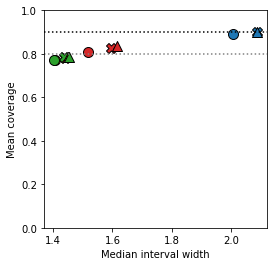

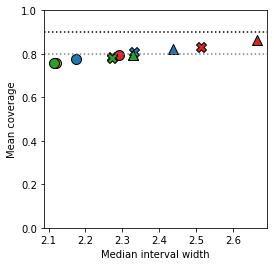

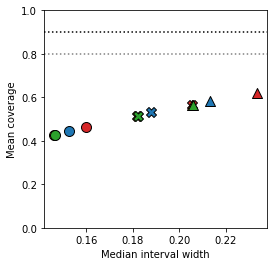

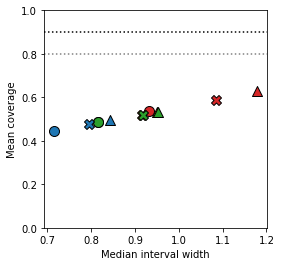

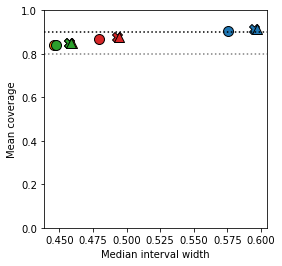

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

orders = [1, 2, 3] ## IF orders in ascending order

results_airfoil_IFs = pd.read_csv('./Results/2022-07-14_IFs_airfoil_0.75Bias_100Trials.csv')
results_wine_IFs = pd.read_csv('./Results/2022-07-14_IFs_wine_0.4Bias_100Trials.csv')
results_wave_IFs = pd.read_csv('./Results/2022-07-14_IFs_wave_5e-05Bias_100Trials.csv')
results_superconduct_IFs = pd.read_csv('./Results/2022-07-14_IFs_superconduct_0.0003Bias_100Trials.csv')
results_communities_IFs = pd.read_csv('./Results/2022-07-14_IFs_communities_0.75Bias_100Trials.csv')

results_all = [results_airfoil_IFs, results_wine_IFs, results_wave_IFs, results_superconduct_IFs, results_communities_IFs]
dataset_names = ['airfoil', 'wine', 'wave', 'superconduct', 'communities']

for results_df in results_all:
    IF_method_names_all = []
    for o in orders:
        IF_method_names_all.append(['IF'+str(o)+'-JAWA', 'IF'+str(o)+'-jackknife+', 'IF'+str(o)+'-jackknife', 'IF'+str(o)+'-jackknife-mm'])

    coverages_all = []
    widths_all = []
    inverse_widths_all = []
    for method_names_order in IF_method_names_all:
        coverages_order = []
        widths_order = []
        inverse_widths_order = []
        for method_name in method_names_order:
            coverages_order.append(results_df[results_df['method']==method_name]['coverage'].mean())
            widths_order.append(results_df[results_df['method']==method_name]['width'].median())
            inverse_widths_order.append(1/results_df[results_df['method']==method_name]['width'].median())
        coverages_all.append(coverages_order)
        widths_all.append(widths_order)
        inverse_widths_all.append(inverse_widths_order)

    ## Plot data
    markers = ["o", "X", "^"]
    colors = ['C0', 'C1', 'C2', 'C3']
    plt.figure(figsize=(4,4))
    for i in range(0, len(orders)):
        
        for j in range(0, 4):
#             plt.scatter(inverse_widths_all[i][j], coverages_all[i][j], marker=markers[i], color = colors[j], s=100, edgecolors='black')
            plt.scatter(widths_all[i][j], coverages_all[i][j], marker=markers[i], color = colors[j], s=100, edgecolors='black')

    plt.xlabel("Median interval width")
    plt.ylabel("Mean coverage")
    plt.axhline(0.9,linestyle='dotted',color='black')
    plt.axhline(0.8,linestyle='dotted',color='gray')
    plt.ylim([0, 1])
    plt.show()


## Plotting JAW results

In [18]:
results_airfoil_NN_IFs = pd.read_csv('./Results/airfoil_NN_1.0Bias_200Trials.csv')
set(results_airfoil_NN_IFs['method'])

{'CV+', 'JAW', 'jackknife', 'jackknife+', 'jackknife-mm', 'naive', 'split'}

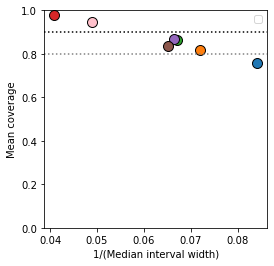

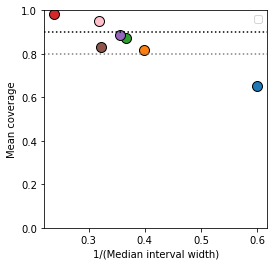

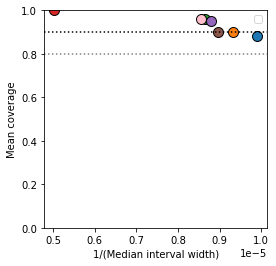

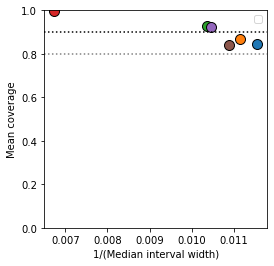

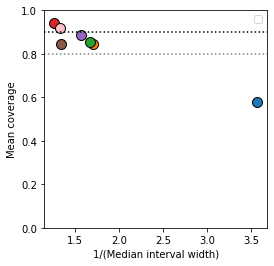

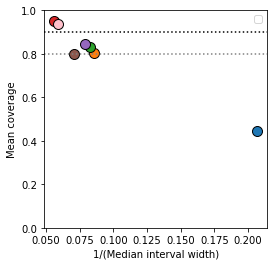

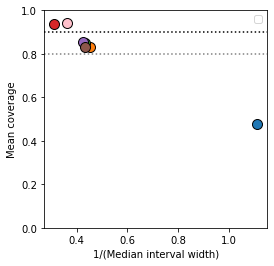

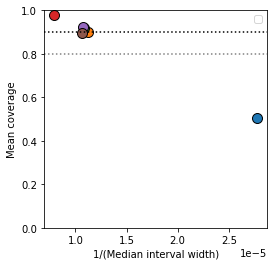

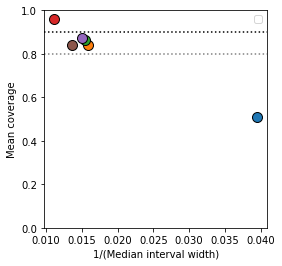

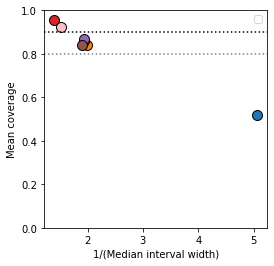

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

mu_fun_names = ['neural_net', 'random_forest'] ## IF orders in ascending order
method_names = ['naive', 'jackknife', 'jackknife+', 'jackknife-mm',  'CV+', 'split', 'JAW']

results_airfoil_NN_IFs = pd.read_csv('./Results/airfoil_NN_1.0Bias_200Trials.csv')
results_wine_NN_IFs = pd.read_csv('./Results/wine_NN_0.65Bias_200Trials.csv')
results_wave_NN_IFs = pd.read_csv('./Results/wave_NN_0.0003Bias_200Trials.csv')
results_superconduct_NN_IFs = pd.read_csv('./Results/superconduct_NN_0.0006Bias_200Trials.csv')
results_communities_NN_IFs = pd.read_csv('./Results/communities_NN_0.75Bias_200Trials.csv')

results_airfoil_RF_IFs = pd.read_csv('./Results/airfoil_RF_1.0Bias_200Trials.csv')
results_wine_RF_IFs = pd.read_csv('./Results/wine_RF_0.65Bias_200Trials.csv')
results_wave_RF_IFs = pd.read_csv('./Results/wave_RF_0.0003Bias_200Trials.csv')
results_superconduct_RF_IFs = pd.read_csv('./Results/superconduct_RF_0.0006Bias_200Trials.csv')
results_communities_RF_IFs = pd.read_csv('./Results/communities_RF_0.75Bias_200Trials.csv')

results_NN_all = [results_airfoil_NN_IFs, results_wine_NN_IFs, results_wave_NN_IFs, results_superconduct_NN_IFs, results_communities_NN_IFs]
results_RF_all = [results_airfoil_RF_IFs, results_wine_RF_IFs, results_wave_RF_IFs, results_superconduct_RF_IFs, results_communities_RF_IFs]
results_ALL = [results_NN_all, results_RF_all]

dataset_names = ['airfoil', 'wine', 'wave', 'superconduct', 'communities']


## NN
for results_df_method in results_ALL:
    for results_df in results_df_method:

        coverages_all = []
        widths_all = []
        inverse_widths_all = []

        for method_name in method_names:
            coverages_all.append(results_df[results_df['method']==method_name]['coverage'].mean())
            widths_all.append(results_df[results_df['method']==method_name]['width'].median())
            inverse_widths_all.append(1/results_df[results_df['method']==method_name]['width'].median())


        ## Plot data
        colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'pink']
        plt.figure(figsize=(4,4))

        for j in range(0, len(method_names)):
    #             plt.scatter(inverse_widths_all[i][j], coverages_all[i][j], marker=markers[i], color = colors[j], s=100, edgecolors='black')
            plt.scatter(inverse_widths_all[j], coverages_all[j], marker='o', color = colors[j], s=100, edgecolors='black')

        plt.xlabel("1/(Median interval width)")
        plt.ylabel("Mean coverage")
        plt.axhline(0.9,linestyle='dotted',color='black')
        plt.axhline(0.8,linestyle='dotted',color='gray')
        plt.ylim([0, 1])
        plt.legend()
        plt.show()
